In [73]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
folder_path = 'mouseTrackingData'

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
dataframes = [pd.read_csv(file) for file in csv_files]
# filenames = [os.path.basename(file) for file in csv_files]


### Blockpaare erstellen und waiting Phase ausschließen

In [3]:
block_pairs = [(1, 2), (3, 4), (5, 6), (7, 8)]
all_blocks = {f"{a}_{b}": [] for a, b in block_pairs}

for df in dataframes:
    df = df[df['phase'] != 'waitingForTarget']  # Phase-Filter
    for a, b in block_pairs:
        df_block = df[df['round'].isin([a, b])].reset_index(drop=True)
        all_blocks[f"{a}_{b}"].append(df_block)

### Blöcke nach round und trial gruppieren (eine zeile enthält einen trial)

In [28]:
grouped_blocks = {
    '1_2': [],
    '3_4': [],
    '5_6': [],
    '7_8': []
}

for key in grouped_blocks.keys():
    for df in all_blocks[key]:
        df_grouped = df.groupby(['round', 'trial']).agg({
            'mouse_x': list,
            'mouse_y': list,
            'mouse_dx': list,
            'mouse_dy': list,
            'version': 'first'
        }).reset_index()
        grouped_blocks[key].append(df_grouped)


In [29]:
len(grouped_blocks["1_2"])

50

In [30]:
grouped_df_1_2 = grouped_blocks["1_2"]
grouped_df_3_4 = grouped_blocks["3_4"]
grouped_df_5_6 = grouped_blocks["5_6"]
grouped_df_7_8 = grouped_blocks["7_8"]

In [31]:
len(grouped_df_1_2)

50

### Mausdaten Auf selben startpunkt (0,0) setzen und interpolieren auf 100 Werte (100 timesteps dann)

In [50]:
def normalize_and_interpolate(row):
    # Normalisieren (Startpunkt auf 0,0 setzen)
    x_positions = np.array(row["mouse_x"])
    y_positions = np.array(row["mouse_y"])
    x_start, y_start = x_positions[0], y_positions[0]
    
    x_norm = x_positions - x_start
    y_norm = y_positions - y_start

    # Interpolieren auf 100 Punkte
    original_length = len(x_norm)
    original_time = np.linspace(0, 1, original_length)
    new_time = np.linspace(0, 1, 100)
    
    x_interp = np.interp(new_time, original_time, x_norm)
    y_interp = np.interp(new_time, original_time, y_norm)
    
    row["mouse_x"] = x_interp
    row["mouse_y"] = y_interp
    
    return row

In [51]:
grouped_dfs = {
    '1_2': grouped_df_1_2,
    '3_4': grouped_df_3_4,
    '5_6': grouped_df_5_6,
    '7_8': grouped_df_7_8
}

processed_dfs = {}

for key, df_list in grouped_dfs.items():
    processed_dfs[key] = [df.apply(normalize_and_interpolate, axis=1) for df in df_list]


In [52]:
df_lld = {}
df_rld = {}

for key, df_list in processed_dfs.items():
    df_lld[key] = []
    df_rld[key] = []
    
    for df in df_list:
        version = df.iloc[0]['version']
        if version == 'lld':
            df_lld[key].append(df)
        elif version == 'rld':
            df_rld[key].append(df)


In [53]:
len(df_rld["1_2"])

25

## Hinzufügen von targetPos um herauszufinden, wie sich die mauspositionen je nach seite unterscheiden

In [49]:
def get_target_pos(row):
    last_x = row['mouse_x'][-1]
    return 'r' if last_x > 0 else 'l'

df['targetPos'] = df.apply(get_target_pos, axis=1)

In [ ]:
# für lld

for key in df_lld.keys():
    for i, df in enumerate(df_lld[key]):
        df_lld[key][i] = df.copy()
        df_lld[key][i]['targetPos'] = df_lld[key][i].apply(get_target_pos, axis=1)

In [ ]:
df_lld["1_2"][0]

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version,targetPos
0,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
1,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,r
2,1,3,"[0.0, 0.0, -0.007444444444444433, -0.013060606...","[0.0, 0.0, -0.008121212121212123, -0.013545454...","[0.0, 0.0, -0.1, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0...","[0.0, 0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1,...",lld,l
3,1,4,"[0.0, 0.02493939393939394, 0.03196969696969697...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01263636363636362...","[0.0, 0.2, 0.0, 0.0, 0.2, 0.0, 0.3, 0.0, 0.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, -0.3...",lld,l
4,1,5,"[0.0, 0.0, 0.0, 0.0, 0.004222222222222222, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,r
...,...,...,...,...,...,...,...,...
115,2,56,"[0.0, 0.03296969696969697, 0.05846464646464646...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3, 0.2, 0.1, 0.4, 0.4, 0.6, 0.3, 0.2, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
116,2,57,"[0.0, -0.024333333333333276, -0.03822222222222...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,r
117,2,58,"[0.0, -0.029363636363636394, -0.05963636363636...","[0.0, -0.006181818181818188, -0.01212121212121...","[0.0, -0.5, -0.6, -1.1, -0.6, -0.3, 0.0, 0.0, ...","[0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",lld,l
118,2,59,"[0.0, -0.13812121212121214, -0.276242424242424...","[0.0, -0.024323232323232323, -0.04864646464646...","[-0.9, -2.5, -3.9, -3.7, -2.3, -1.6, -0.9, -0....","[-0.5, -0.3, 0.0, 0.0, 0.0, 0.1, 0.0, 0.2, 0.0...",lld,l


In [ ]:
# für rld

for key in df_rld.keys():
    for i, df in enumerate(df_rld[key]):
        df_rld[key][i] = df.copy()
        df_rld[key][i]['targetPos'] = df_rld[key][i].apply(get_target_pos, axis=1)

In [80]:
df_lld["1_2"][0].head()

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version,targetPos
0,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
1,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,r
2,1,3,"[0.0, 0.0, -0.007444444444444433, -0.013060606...","[0.0, 0.0, -0.008121212121212123, -0.013545454...","[0.0, 0.0, -0.1, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0...","[0.0, 0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1,...",lld,l
3,1,4,"[0.0, 0.02493939393939394, 0.03196969696969697...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01263636363636362...","[0.0, 0.2, 0.0, 0.0, 0.2, 0.0, 0.3, 0.0, 0.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, -0.3...",lld,l
4,1,5,"[0.0, 0.0, 0.0, 0.0, 0.004222222222222222, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,r


In [79]:
df_rld["1_2"][0].head()

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version,targetPos
0,1,1,"[0.0, 0.02227272727272727, 0.04754545454545454...","[0.0, -0.00827272727272728, -0.017363636363636...","[0.0, 0.3, 0.3, 0.0, 0.0, 0.3, 0.3, 0.5, 1.0, ...","[0.0, -0.1, -0.1, -0.1, -0.1, 0.0, -0.1, -0.3,...",rld,l
1,1,2,"[0.0, 0.004030303030303034, 0.0074545454545454...","[0.0, -0.0011515151515151527, -0.0020000000000...","[0.0, 0.0, 0.0, 0.0, -0.3, -1.0, -2.5, -2.8, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l
2,1,3,"[0.0, -0.021838383838383834, -0.04367676767676...","[0.0, -0.0018585858585858574, -0.0037171717171...","[0.0, -0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,r
3,1,4,"[0.0, 0.0, 0.0, 0.0, 0.015454545454545469, 0.0...","[0.0, 0.004686868686868675, 0.0085151515151514...","[0.0, 0.0, 0.0, 0.4, 0.5, 0.1, 0.3, 0.0, 0.0, ...","[0.1, 0.0, 0.0, 0.1, 0.3, 0.1, 0.9, 1.3, 2.3, ...",rld,r
4,1,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l


### Jetzt werden die zwei conditions noch nach targetPos aufgesplittet

In [82]:
# l und r in left condition aufteilen

df_lld_left_target = {}
df_lld_right_target = {}

for key, df_list in df_lld.items():
    df_lld_left_target[key] = []
    df_lld_right_target[key] = []
    
    for df in df_list:
        df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
        df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
        
        df_lld_left_target[key].append(df_left)
        df_lld_right_target[key].append(df_right)


In [83]:
df_lld_left_target["1_2"][0]

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version,targetPos
0,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
1,1,3,"[0.0, 0.0, -0.007444444444444433, -0.013060606...","[0.0, 0.0, -0.008121212121212123, -0.013545454...","[0.0, 0.0, -0.1, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0...","[0.0, 0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1,...",lld,l
2,1,4,"[0.0, 0.02493939393939394, 0.03196969696969697...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01263636363636362...","[0.0, 0.2, 0.0, 0.0, 0.2, 0.0, 0.3, 0.0, 0.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, -0.3...",lld,l
3,1,7,"[0.0, -0.044686868686868685, -0.09414141414141...","[0.0, -0.019949494949494953, -0.04347474747474...","[-0.2, -0.4, -0.4, -0.6, -0.4, -0.4, -0.2, -0....","[0.0, -0.2, -0.2, -0.2, 0.0, -0.2, 0.0, 0.0, 0...",lld,l
4,1,10,"[0.0, -0.08517171717171718, -0.187262626262626...","[0.0, -0.030686868686868686, -0.06743434343434...","[-1.0, -0.8, -1.4, -1.1, -0.8, -0.7, -0.2, 0.0...","[-0.4, -0.3, -0.5, -0.3, -0.2, -0.2, 0.0, 0.0,...",lld,l
5,1,16,"[0.0, -0.012303030303030314, -0.01540404040404...","[0.0, -0.003101010101010104, -0.00400000000000...","[-0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
6,1,17,"[0.0, -0.004303030303030307, -0.00686868686868...","[0.0, 0.005737373737373743, 0.0093030303030303...","[-0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
7,1,20,"[0.0, 0.0007373737373737381, 0.001000000000000...","[0.0, -0.00811111111111112, -0.023343434343434...","[0.0, 0.0, 0.0, -0.2, -0.2, -0.1, -0.5, -0.7, ...","[-0.2, 0.0, -0.2, 0.0, -0.1, -0.1, -0.2, -0.2,...",lld,l
8,1,22,"[0.0, 0.02351515151515151, 0.03167676767676768...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
9,1,24,"[0.0, -0.09494949494949492, -0.189666666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...","[-1.3, -1.1, -0.9, -0.4, -0.4, -0.2, -0.2, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, ...",lld,l


In [84]:
# l und r in right condition aufteilen

df_rld_left_target = {}
df_rld_right_target = {}

for key, df_list in df_rld.items():
    df_rld_left_target[key] = []
    df_rld_right_target[key] = []
    
    for df in df_list:
        df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
        df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
        
        df_rld_left_target[key].append(df_left)
        df_rld_right_target[key].append(df_right)


In [85]:
df_lld_left_target["1_2"][0].head()

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version,targetPos
0,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,l
1,1,3,"[0.0, 0.0, -0.007444444444444433, -0.013060606...","[0.0, 0.0, -0.008121212121212123, -0.013545454...","[0.0, 0.0, -0.1, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0...","[0.0, 0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1,...",lld,l
2,1,4,"[0.0, 0.02493939393939394, 0.03196969696969697...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01263636363636362...","[0.0, 0.2, 0.0, 0.0, 0.2, 0.0, 0.3, 0.0, 0.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, -0.3...",lld,l
3,1,7,"[0.0, -0.044686868686868685, -0.09414141414141...","[0.0, -0.019949494949494953, -0.04347474747474...","[-0.2, -0.4, -0.4, -0.6, -0.4, -0.4, -0.2, -0....","[0.0, -0.2, -0.2, -0.2, 0.0, -0.2, 0.0, 0.0, 0...",lld,l
4,1,10,"[0.0, -0.08517171717171718, -0.187262626262626...","[0.0, -0.030686868686868686, -0.06743434343434...","[-1.0, -0.8, -1.4, -1.1, -0.8, -0.7, -0.2, 0.0...","[-0.4, -0.3, -0.5, -0.3, -0.2, -0.2, 0.0, 0.0,...",lld,l


In [86]:
df_rld_left_target["1_2"][0].head()

,round,trial,mouse_x,mouse_y,mouse_dx,mouse_dy,version,targetPos
0,1,1,"[0.0, 0.02227272727272727, 0.04754545454545454...","[0.0, -0.00827272727272728, -0.017363636363636...","[0.0, 0.3, 0.3, 0.0, 0.0, 0.3, 0.3, 0.5, 1.0, ...","[0.0, -0.1, -0.1, -0.1, -0.1, 0.0, -0.1, -0.3,...",rld,l
1,1,2,"[0.0, 0.004030303030303034, 0.0074545454545454...","[0.0, -0.0011515151515151527, -0.0020000000000...","[0.0, 0.0, 0.0, 0.0, -0.3, -1.0, -2.5, -2.8, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l
2,1,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l
3,1,6,"[0.0, -0.07139393939393987, -0.098848484848485...","[0.0, 0.015969696969696984, 0.0565454545454545...","[0.0, -0.5, 0.0, 0.0, -0.3, 0.0, -0.1, -0.1, 0...","[0.0, 0.1, 0.3, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ...",rld,l
4,1,7,"[0.0, 0.012020202020201954, 0.0190707070707069...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,l


### Funktion für Berechnung Durschnittsbewegungskurve

In [87]:
def calculate_average_trajectory(df_list):
    """Berechnet den Durchschnitt aller Trajektorien"""
    all_trajectories = []
    
    for df in df_list:
        for idx, row in df.iterrows():
            if hasattr(row['mouse_x'], '__len__') and len(row['mouse_x']) > 0:
                all_trajectories.append(row['mouse_x'])
    
    if not all_trajectories:
        return np.array([])
    
    # Finde die maximale Länge
    max_length = max(len(traj) for traj in all_trajectories)
    
    # Interpoliere alle Trajektorien auf die gleiche Länge
    interpolated_trajectories = []
    for traj in all_trajectories:
        if len(traj) > 1:
            # Interpoliere auf max_length
            old_indices = np.linspace(0, len(traj)-1, len(traj))
            new_indices = np.linspace(0, len(traj)-1, max_length)
            interpolated = np.interp(new_indices, old_indices, traj)
            interpolated_trajectories.append(interpolated)
    
    if interpolated_trajectories:
        return np.mean(interpolated_trajectories, axis=0)
    else:
        return np.array([])


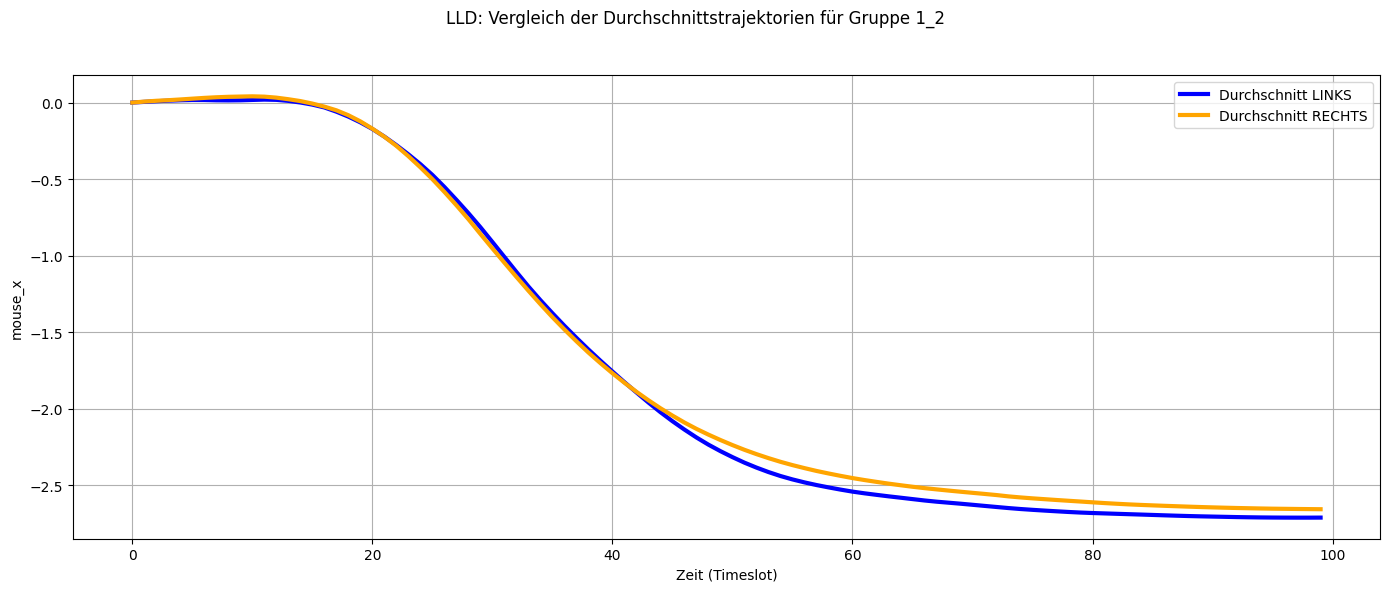

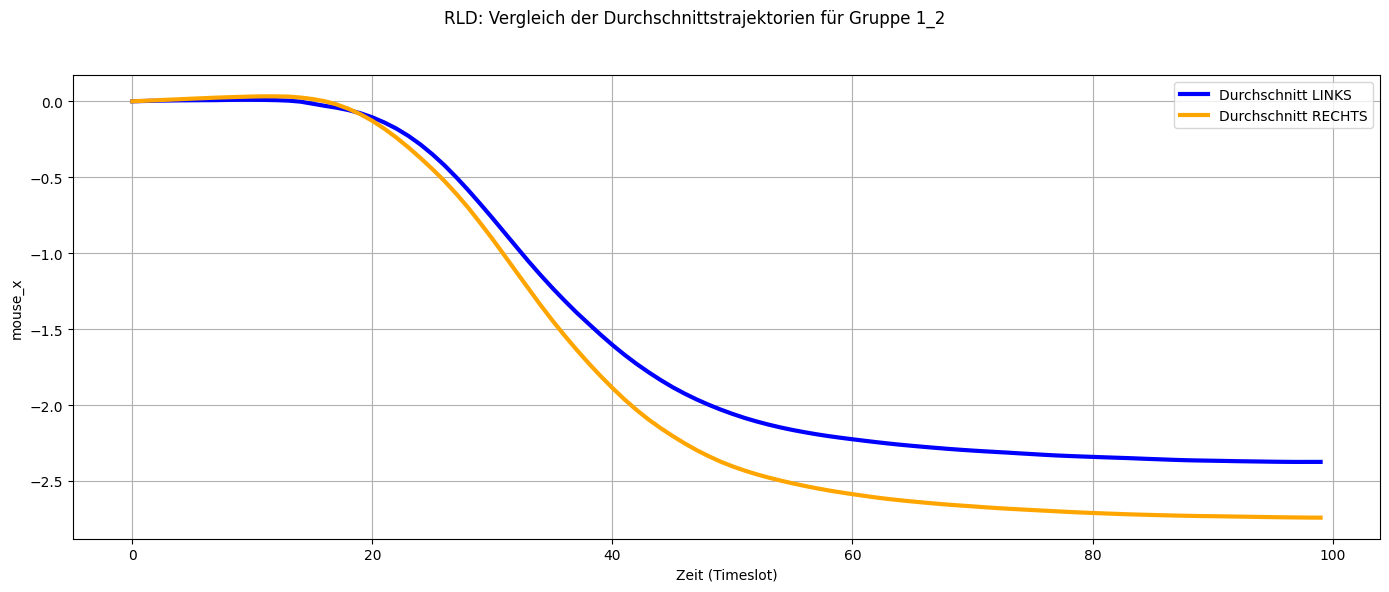

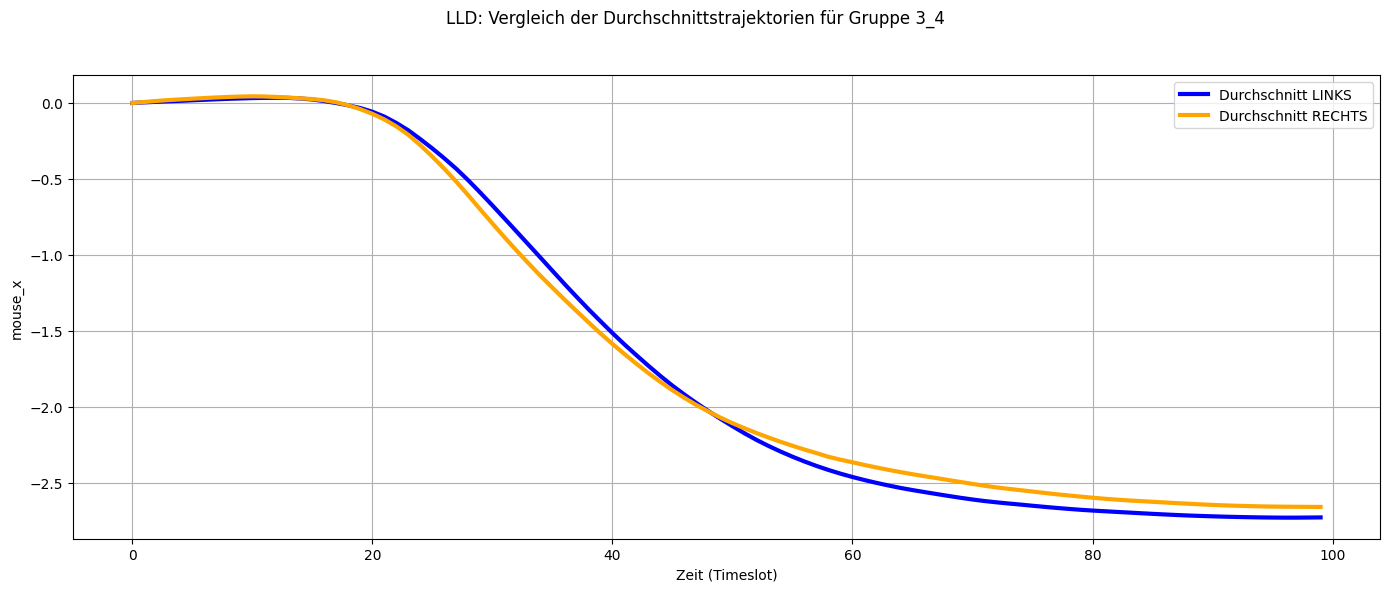

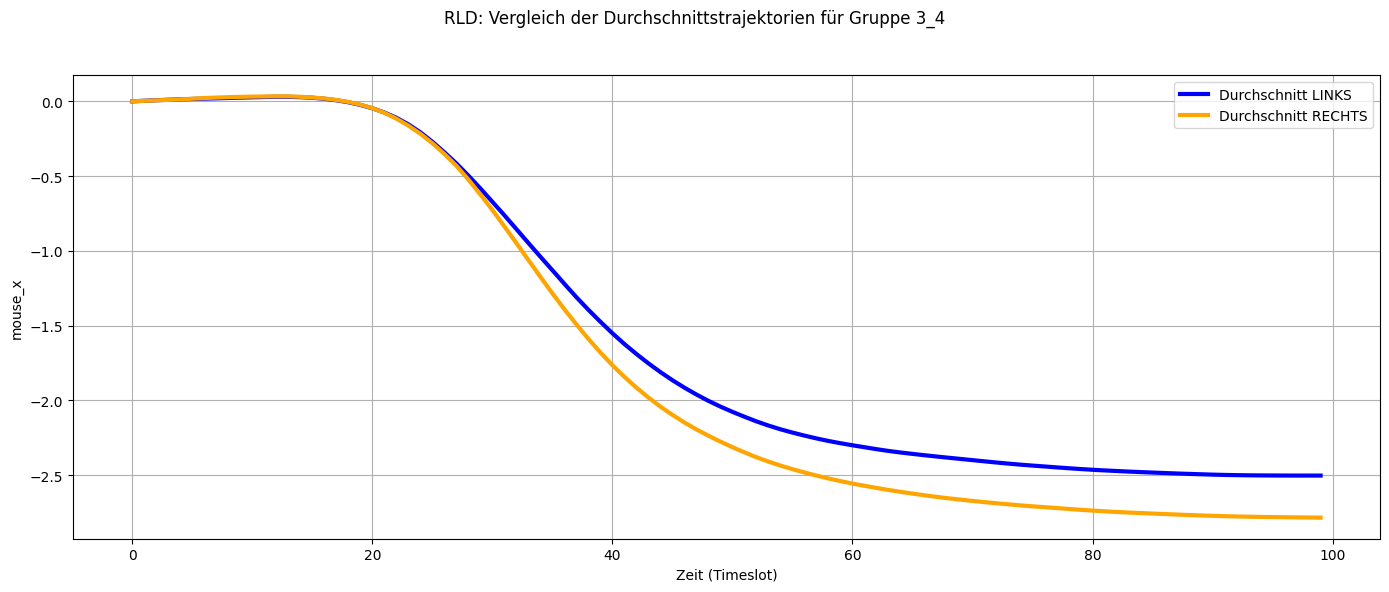

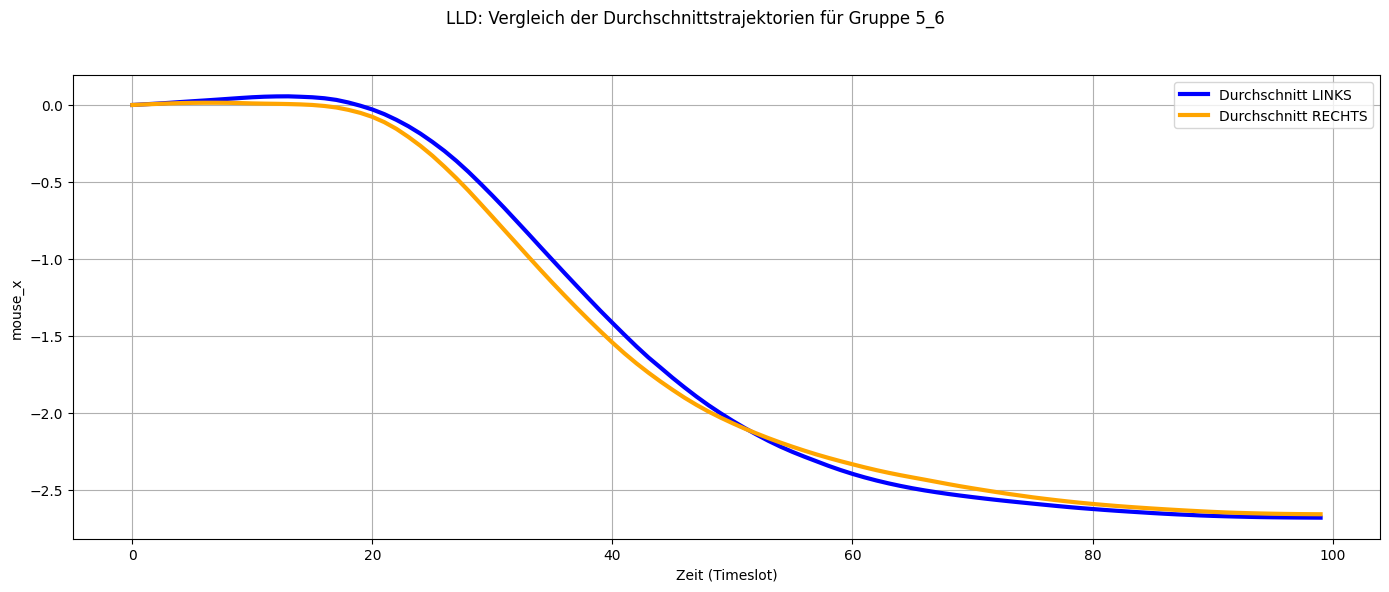

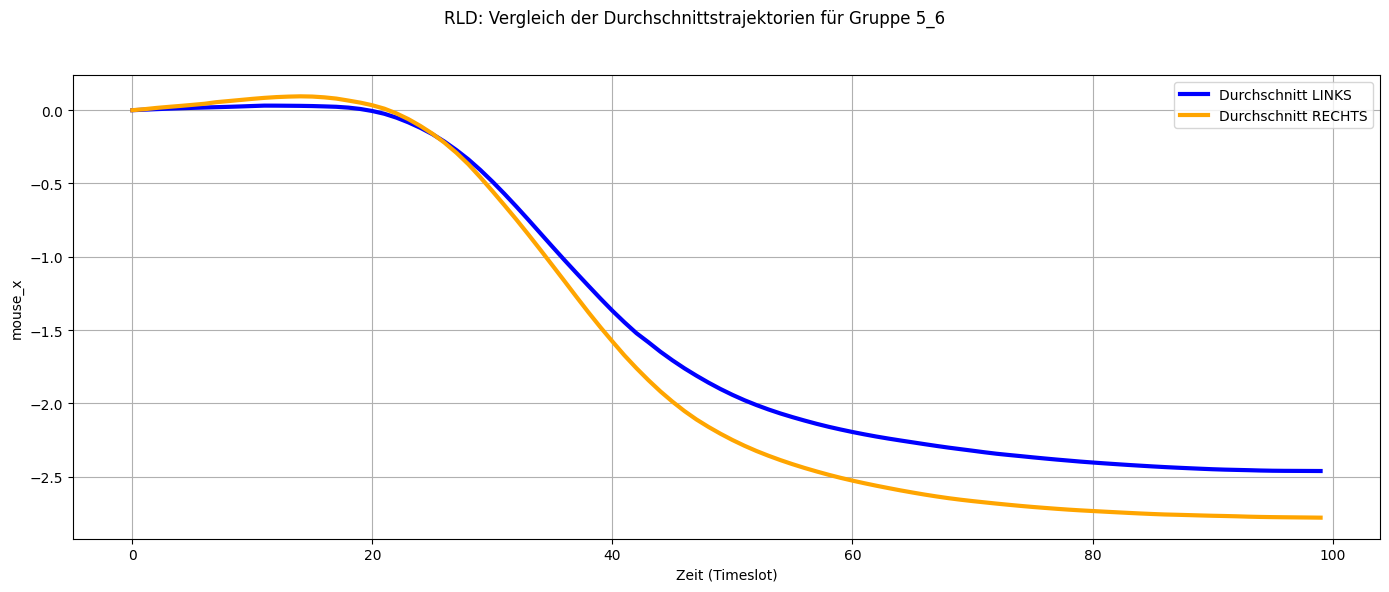

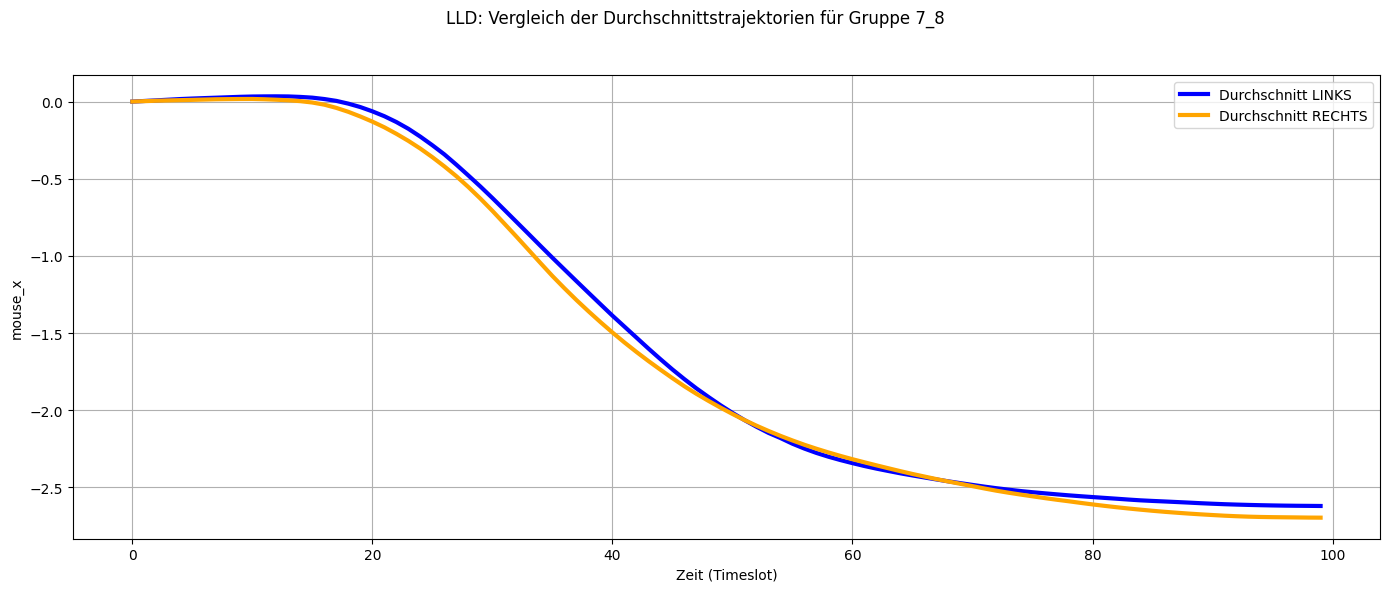

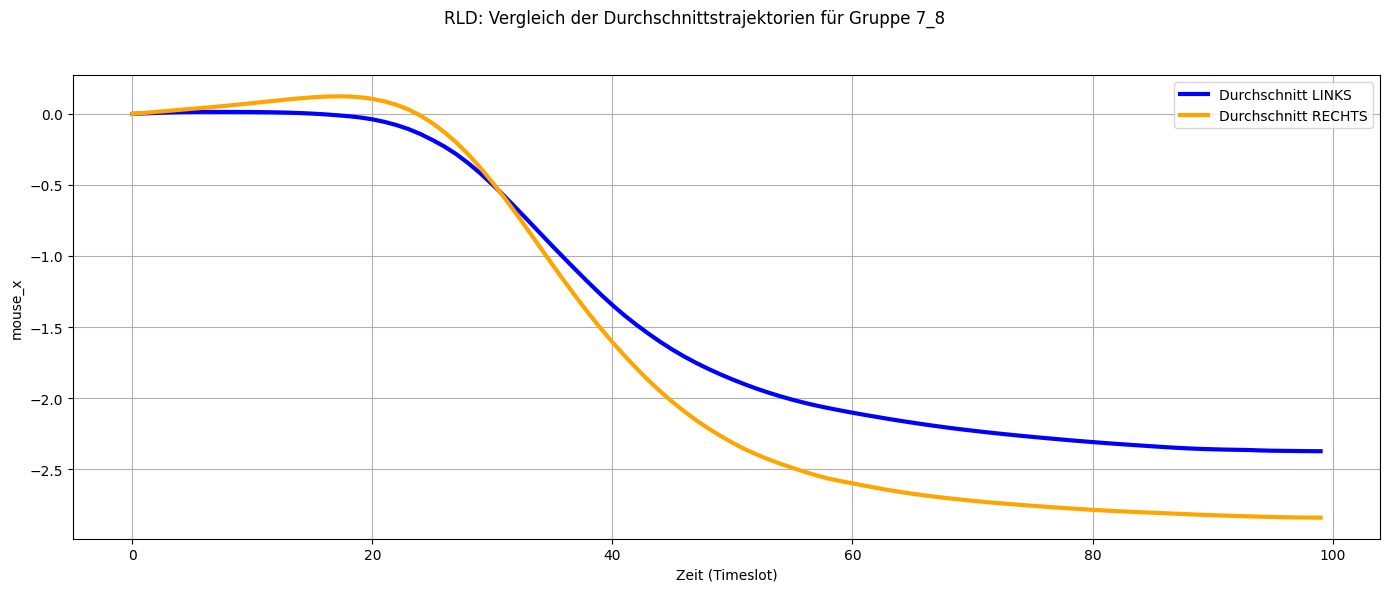

In [88]:
for key in ['1_2', '3_4', '5_6', '7_8']:
    # Durchschnittstrajektorien berechnen
    avg_lld_left = calculate_average_trajectory(df_lld_left_target[key])
    avg_lld_right = calculate_average_trajectory(df_lld_right_target[key])
    avg_rld_left = calculate_average_trajectory(df_rld_left_target[key])
    avg_rld_right = calculate_average_trajectory(df_rld_right_target[key])
    
    # Plot für lld
    plt.figure(figsize=(14, 6))
    plt.suptitle(f'LLD: Vergleich der Durchschnittstrajektorien für Gruppe {key}')
    
    if len(avg_lld_left) > 0:
        plt.plot(range(len(avg_lld_left)), avg_lld_left, color='blue', linewidth=3, label='Durchschnitt LINKS')
    if len(avg_lld_right) > 0:
        plt.plot(range(len(avg_lld_right)), -avg_lld_right, color='orange', linewidth=3, label='Durchschnitt RECHTS')
    
    plt.xlabel('Zeit (Timeslot)')
    plt.ylabel('mouse_x')
    plt.legend()
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Plot für rld
    plt.figure(figsize=(14, 6))
    plt.suptitle(f'RLD: Vergleich der Durchschnittstrajektorien für Gruppe {key}')
    
    if len(avg_rld_left) > 0:
        plt.plot(range(len(avg_rld_left)), avg_rld_left, color='blue', linewidth=3, label='Durchschnitt LINKS')
    if len(avg_rld_right) > 0:
        plt.plot(range(len(avg_rld_right)), -avg_rld_right, color='orange', linewidth=3, label='Durchschnitt RECHTS')
    
    plt.xlabel('Zeit (Timeslot)')
    plt.ylabel('mouse_x')
    plt.legend()
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
